<a href="https://colab.research.google.com/github/dhanushbiligiri/Time-Series-Forecasting-For-Mortality/blob/main/BigData_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forcasting on deaths data 


## PROBLEM STATEMENT
*   The dataset includes data on death rates and their reasons in the United States.
*   We aim to build a model which would effectively forcast mortality patterns occurring in the dataset over a period of 11 years.





## Motive of the project

*   **Government**: The government will require this data to understand the different causes of death and try to come up with better health care policies .
Fitness Industry: The fitness industry will obtain enough knowledge to develop 
*   **Fitness Industry**: The fitness industry will obtain enough knowledge to develop products relating to specific diseases to promote a healthier lifestyle.
*   **Pharmaceutical Industry**: They can use this information to help with the production of much needed medicine and vaccinations. They can perform targeted research on most common occurring deaths to produce necessary medicines.






Imports for the project

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", message="Some warning message")

In [ ]:
 # Creating Variable names for pandas DataFrame
data = [] 
for i in range(2005,2016):
    data.append('deaths_'+str(i))

## DATA SOURCE


*   The data is sourced from the Centers for Disease Control and Prevention (CDC) National Vital Statistics System.
*   We have obtained the datafiles in both JSON and CSV formats. It contains the data from the year 2005 to 2015.
*   There are a total of 22 files( JSON and CSV- each 11 files) which totally consists of 77 attributes and 27 million instances of death.
*   For our analysis we are considering 6 features from the dataset.
*   The information, which includes the deceased's demographics, cause of demise, and place of death, is taken from death records submitted in the United States.







In [ ]:
from google.colab import drive
drive.mount(r'/content/drive')

Mounted at /content/drive


# Get keys from JSON file.

## Sample Example of Keys in JSON file
### resident_status

{'1': 'RESIDENTS', '2': 'INTRASTATE NONRESIDENTS', '3': 'INTERSTATE NONRESIDENTS', '4': 'FOREIGN RESIDENTS'}

### month_of_death

{'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}

### current_data_year

{'2005': '2005'}

### race_recode_5

{'0': 'Other (Puerto Rico only)', '1': 'White', '2': 'Black', '3': 'American Indian', '4': 'Asian or Pacific Islander'}

### 358_cause_recode

### Extracting Disese keys list of individual disease

In [ ]:
keys = []
for i in range(2005,2006): 
    loc = r'/content/drive/MyDrive/Machine_Learning/project/data/'+ str(i)+'_codes.json'
    dic = ''
    with open(loc, 'r') as f:
        data = f.read()
        data = data.replace('NaN', 'np.nan')
        dic=data
    d = eval(dic)
    keys.append(d)

In [ ]:
def keyFinder(dic,lst):
    for key in dic:
        dic[key] = str(dic[key]).lower()
    keys_lst = []
    for key, sent in dic.items():
        for word in lst:
            if word in sent:
                keys_lst.append(int(key))
    return keys_lst

We are considering the 7 major causes of death in the United States of America for this project . 
1.   Cancer
2.   Heart
1.   Respiratory
2.   Stroke
1.   Accidents
2.   Diabetes
1.   Oldage










In [ ]:
heart_disese_keys = keyFinder(keys[0]['358_cause_recode'],["heart"])
cancer_disese_keys = keyFinder(keys[0]['358_cause_recode'],["malignant","benign","Leukemia"])
respiratory_disese_keys = keyFinder(keys[0]['358_cause_recode'],["chronic lower","respiratory"])
stroke_disese_keys = keyFinder(keys[0]['358_cause_recode'],["stroke","cerebrovascular"])
accidents_disese_keys = keyFinder(keys[0]['358_cause_recode'],["accidents"])
diabetes_disese_keys = keyFinder(keys[0]['358_cause_recode'],["diabetes"])
oldAge_disese_keys = keyFinder(keys[0]['358_cause_recode'],["alzheimer=s","parkinson=s"])

In [ ]:
diseases = {'heart':heart_disese_keys,'cancer':cancer_disese_keys,'respiratory':respiratory_disese_keys,'stroke':stroke_disese_keys,'accidents':accidents_disese_keys,'diabetes':diabetes_disese_keys,'oldAge':oldAge_disese_keys}
diseases_keys= set(heart_disese_keys+cancer_disese_keys+respiratory_disese_keys+stroke_disese_keys+accidents_disese_keys+diabetes_disese_keys+oldAge_disese_keys)

# List of dataframes from 2005 to 2015

We have considered the 6 features for our analysis out of 358 features. We can observe that 6 featires are 'current_data_year', 'month_of_death', 'resident_status', 'sex 	race_recode_5 	358_cause_recode

In [ ]:
Overall_data = []
for i,j in zip(range(2005,2016),data): #change range from 2005 to 2016
    loc = r'/content/drive/MyDrive/Machine_Learning/project/data/'+str(i)+'_data.csv'
    j = pd.read_csv(loc)[['current_data_year','month_of_death','resident_status','sex','race_recode_5','358_cause_recode']]
    j.dropna(how='any',axis=1,inplace=True) #Droping Null Values
    j = j[j['358_cause_recode'].isin(diseases_keys)]
    Overall_data.append(j)

<ipython-input-11-fdea30543916>:7: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  j = pd.read_csv(loc)[['current_data_year','month_of_death','resident_status','sex','race_recode_5','358_cause_recode']]
<ipython-input-11-fdea30543916>:7: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  j = pd.read_csv(loc)[['current_data_year','month_of_death','resident_status','sex','race_recode_5','358_cause_recode']]
<ipython-input-11-fdea30543916>:7: DtypeWarning: Columns (39,40,41,42,43,44,45,46,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  j = pd.read_csv(loc)[['current_data_year','month_of_death','resident_status','sex','race_recode_5','358_cause_recode']]
<ipython-input-11-fdea30543916>:7: DtypeWarning: Columns (39,40,41,42,43,44,45,

In [ ]:
data = pd.concat(Overall_data).reset_index()
print(data.shape)

(8593283, 7)


In [ ]:
data = data.drop('index', axis=1)
data.head(2)

,current_data_year,month_of_death,resident_status,sex,race_recode_5,358_cause_recode
0,2005,1,1,F,1,98
1,2005,1,1,F,1,239


# Data Preprocessing and Exploratory data analysis analysis




*   We adopted copule of techniques on how to create a features from the different kaggle timeseries analysis techniques [Kaggle](https://www.kaggle.com/code/jswxhd/cdc-modeling-2-trend-fitting#kln-160).



In [ ]:
#changing the year into monhts to create a time series data
data_1 = data[['resident_status','sex','race_recode_5','358_cause_recode']]
data_1['month'] = (data['current_data_year']-2005)*12+data['month_of_death'] 
 # Changing the Male and felame data in the dataframe
data_1['sex'] = data_1['sex'].replace({'M': 1, 'F': 0})

<ipython-input-14-81d2c04050fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['month'] = (data['current_data_year']-2005)*12+data['month_of_death']
<ipython-input-14-81d2c04050fc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['sex'] = data_1['sex'].replace({'M': 1, 'F': 0})


In [ ]:
cause = {}
for i,j in zip(diseases.keys(),list(diseases.values())):
    for keys in j:
        cause[keys] = i
data_1['Cause'] = data_1['358_cause_recode'].apply(lambda x: cause[x])
data_1['Cause'] = data_1['Cause'].replace({'cancer': 1, 'heart': 2, 'respiratory': 3,'stroke': 4, 'accidents': 5,'diabetes': 6, 'oldAge': 7})

In [ ]:
data_1 = data_1.drop('358_cause_recode', axis=1)
data_1['death_count']=1
data_1.head(2)

,resident_status,sex,race_recode_5,month,Cause,death_count
0,1,0,1,1,1,1
1,1,0,1,1,4,1


## Data Exploration



Visualizing the death counts over the months while grouping by 'month','resident_status','sex','race_recode_5','Cause'.

In [ ]:
data_2 = data_1[['month','resident_status','sex','race_recode_5','Cause','death_count']].groupby(['month','resident_status','sex','race_recode_5','Cause']).agg('sum').reset_index()

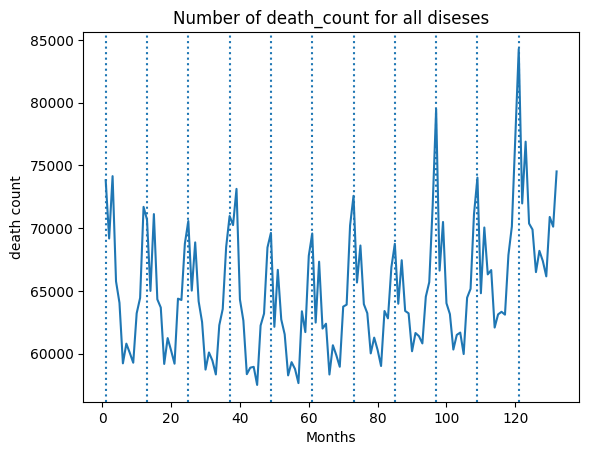

In [ ]:
plt.plot(data_2[['death_count']].groupby(data_2['month']).agg('sum'))#.reset_index())
for i in range(1,132,12):
    plt.axvline(x = i, linestyle =':')
plt.title('Number of death_count for all diseses')
plt.xlabel('Months')
plt.ylabel('death count')
plt.show()

Visualizing the death counts over each month on each year while grouping by 'month','resident_status','sex','race_recode_5','Cause'.

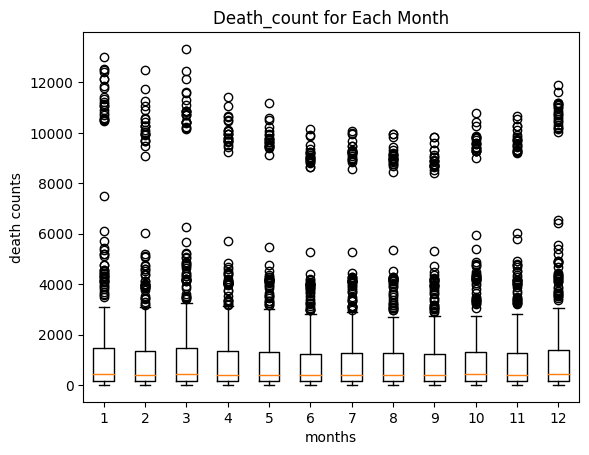

In [ ]:
box_plot = []
for i in range(1,13,1):
    lst = []
    for i in range(i,133,12):
        lst += list(data_2[data_2.month == i]["death_count"])
    box_plot.append(list(set(sorted(lst))))
plt.boxplot(box_plot)
plt.xlabel("months")
plt.ylabel("death counts")
plt.title('Death_count for Each Month')
plt.show()

Trend of deaths while grouping by 'month','resident_status','sex','race_recode_5','Cause'.

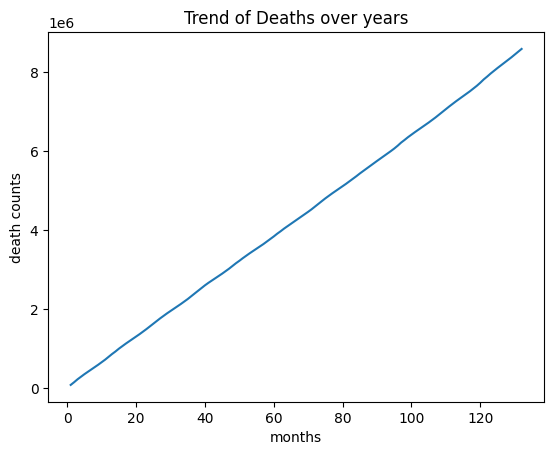

In [ ]:
plt.plot(data_2[['death_count']].groupby(data_2['month']).agg('sum')['death_count'].cumsum())
plt.xlabel("months")
plt.ylabel("death counts")
plt.title('Trend of Deaths over years')
plt.show()

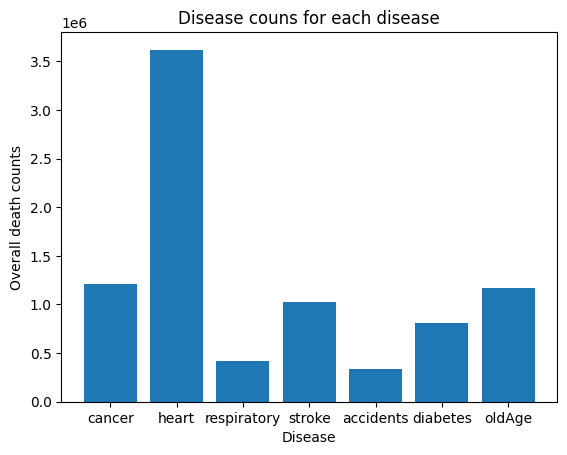

In [ ]:
# plot the bar chart
dic = {1: 'cancer', 2: 'heart', 3: 'respiratory', 4: 'stroke', 5: 'accidents', 6: 'diabetes', 7: 'oldAge'}
x = list(map(lambda x: dic[x], list(data_2[['Cause','death_count']].groupby('Cause').agg('sum').index)))
y = list(data_2[['Cause','death_count']].groupby('Cause').agg('sum').values.flatten())  # flatten the numpy array and convert to list
plt.bar(x, y)

plt.xlabel('Disease')
plt.ylabel('Overall death counts')
plt.title('Disease couns for each disease')

plt.show()


### Feature Engineering

Creating this average column

In [ ]:
def avg_cal(df, groupby_cols, agg_col, new_col_name):
    avg_col = df.groupby(groupby_cols)[agg_col].transform('mean')
    df_copy = df.assign(**{new_col_name: avg_col})
    return df_copy

In [ ]:
data_2=avg_cal(data_2, ['month','resident_status','Cause'], 'death_count', 'resstatus_avg_death')
data_2=avg_cal(data_2, ['month','sex','Cause'], 'death_count', 'sex_avg_death')
data_2=avg_cal(data_2, ['month','race_recode_5','Cause'], 'death_count', 'race_avg_death')

In [ ]:
#Creating the lag features
def lag_feature(df, col, lag):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    
    # Shift the month column by the specified lag
    df_copy['month'] = df_copy['month'] + lag
    
    # Rename the column to include the lag information
    new_col_name = f"{col}_lag_{lag}"
    df_copy.rename(columns={col: new_col_name}, inplace=True)
    
    # Merge the shifted dataframe back into the original dataframe
    df = pd.merge(df, df_copy[['month', 'resident_status', 'sex', 'race_recode_5', 'Cause', new_col_name]], on=['month', 'resident_status', 'sex', 'race_recode_5', 'Cause'], how='left')
    
    return df

In [ ]:
for column in ['death_count','resstatus_avg_death','sex_avg_death','race_avg_death']:
    data_2 = lag_feature(data_2,column,12)
data_2.fillna(0,inplace = True)

In [ ]:
onehot_race = pd.get_dummies(data_2.race_recode_5, prefix='race_code')
data_2 = pd.concat([data_2, onehot_race],axis=1)

In [ ]:
onehot_cause = pd.get_dummies(data_2.Cause, prefix='cause')
data_2 = pd.concat([data_2, onehot_cause],axis=1)

In [ ]:
onehot_res = pd.get_dummies(data_2.resident_status, prefix='res_status')
data_2 = pd.concat([data_2, onehot_res],axis=1)

# ADF Fuler test

In [ ]:
from statsmodels.tsa.stattools import adfuller
result =adfuller(data_2['death_count'])
print("ADF test statistic:", result[0])
print("p-value:", result[1])

ADF test statistic: -21.00823134958686
p-value: 0.0


# Model building

Train test split for the data 

In [ ]:
# Creating the train(JAN 2005- DEC 2014 data) and test data(JAN 2015 - DEC 2015)
def split_data(data, train_month):
    train = data[data.month <= train_month]
    test = data[data.month > train_month]
    train_y = train['death_count']
    train_x = train.drop(['death_count','resident_status','sex','race_recode_5','Cause'], axis=1)
    test_y = test['death_count']
    test_x = test.drop(['death_count','resident_status','sex','race_recode_5','Cause'], axis=1)
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = split_data(data_2, 122)

## Building XGB regression model 

In [ ]:
#Building a gridSearchCV model.
gsc = GridSearchCV(
            estimator=xgb.XGBRegressor(seed=42, tree_method='gpu_hist'),
            param_grid={"n_estimators": [300,400,500],
                        "max_depth": [ 5, 6, 8, 9],
                        "learning_rate": (0.01, 0.02, 0.05),
                        "gamma": [ 0.01, 0.1],
                        "colsample_bytree": [0.6,0.8],
                        'colsample_bynode': [0.6, 0.8] },
            cv=3, scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error'}
            ,refit= 'neg_mean_squared_error'
            ,verbose=2)
# Fitting the train data.
gsc.fit(train_x, train_y)

In [ ]:
gsc.best_params_, gsc.best_score_

Best_Hyper parameters for XGB Regression: ({'colsample_bynode': 0.6,
  'colsample_bytree': 0.6,
  'gamma': 0.01,
  'learning_rate': 0.01,
  'max_depth': 9,
  'n_estimators': 500},
 -98829.19984098592)

In [ ]:
xgb_model = xgb.XGBRegressor(colsample_bynode= 0.6,
  colsample_bytree= 0.6,
  gamma = 0.01,
  learning_rate= 0.01,
  max_depth= 9,
  n_estimators= 500)
xgb_model.fit(train_x,train_y, eval_set=[(train_x,train_y),(test_x,test_y)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:1243.35035	validation_1-rmse:1282.97274
[1]	validation_0-rmse:1231.17252	validation_1-rmse:1270.55272
[2]	validation_0-rmse:1219.11653	validation_1-rmse:1258.52520


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:1207.20992	validation_1-rmse:1246.61518
[4]	validation_0-rmse:1195.51604	validation_1-rmse:1234.71861
[5]	validation_0-rmse:1183.96452	validation_1-rmse:1223.25273
[6]	validation_0-rmse:1173.14891	validation_1-rmse:1211.81823
[7]	validation_0-rmse:1161.61078	validation_1-rmse:1199.95550
[8]	validation_0-rmse:1150.77198	validation_1-rmse:1188.73154
[9]	validation_0-rmse:1139.88834	validation_1-rmse:1177.33387
[10]	validation_0-rmse:1128.71109	validation_1-rmse:1165.76516
[11]	validation_0-rmse:1118.23006	validation_1-rmse:1154.65602
[12]	validation_0-rmse:1107.89322	validation_1-rmse:1143.98462
[13]	validation_0-rmse:1096.98991	validation_1-rmse:1132.95745
[14]	validation_0-rmse:1086.65572	validation_1-rmse:1122.44653
[15]	validation_0-rmse:1076.01837	validation_1-rmse:1111.70205
[16]	validation_0-rmse:1066.24520	validation_1-rmse:1101.08486
[17]	validation_0-rmse:1055.75754	validation_1-rmse:1090.41215
[18]	validation_0-rmse:1049.22245	validation_1-rmse:1083.92134

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.6, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
xgb_predict = xgb_model.predict(test_x)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

r2_xgb = r2_score(test_y, xgb_predict)
print("r2_xgb "+str(r2_xgb))
rmse_xgb = np.sqrt(mean_squared_error(test_y, xgb_predict))
print("rmse_xgb "+str(rmse_xgb))
mae = mean_absolute_error(test_y, xgb_predict)
print("mae "+str(mae))
mape = np.mean(np.abs((np.array(test_y) - np.array(xgb_predict)) / np.array(test_y))) * 100
print("mape "+str(mape))

r2_xgb 0.9986796786395505
rmse_xgb 45.09141330177281
mae 16.813739731687203
mape 45.50608129939015


r2_xgb 0.9986796786395505
rmse_xgb 45.09141330177281
mae 16.813739731687203
mape 45.50608129939015

## SVM regression model

In [ ]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# assume we have a pandas dataframe named 'data' containing the time series data

# Define the hyperparameter ranges for GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 0.01, 0.001],
              'epsilon': [0.01, 0.1, 0.5, 1, 2],
              'kernel': ['rbf']}

# Create the SVM regression model
svr = SVR()

# Define the GridSearchCV object with SVM model and hyperparameters
grid_search = GridSearchCV(svr, param_grid=param_grid, cv=3, verbose=2)

# Fit the GridSearchCV object on the training data
grid_search.fit(train_x, train_y)

# Best para meters for SVM. 
'C': 100, 'epsilon': 2, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
svm = SVR(C=100, epsilon=2, gamma=0.001)
svm.fit(train_x, train_y)

SVR(C=100, epsilon=2, gamma=0.001)

In [ ]:
svm_pred = svm.predict(test_x)

In [ ]:
r2_svm = r2_score(test_y, svm_pred)
print("r2_svm "+str(r2_svm))
rmse_svm = np.sqrt(mean_squared_error(test_y, svm_pred))
print("rmse_svm "+str(rmse_svm))
mae_svm = mean_absolute_error(test_y, svm_pred)
print("mae_svm "+str(mae_svm))
mape_svm = np.mean(np.abs((np.array(test_y) - np.array(svm_pred)) / np.array(test_y))) * 100
print("mape_svm "+str(mape_svm))

r2_svm -0.023021738302728467
rmse_svm 1255.1523801947862
mae_svm 345.16697980162894
mape_svm 994.565949139064


# Conclusion

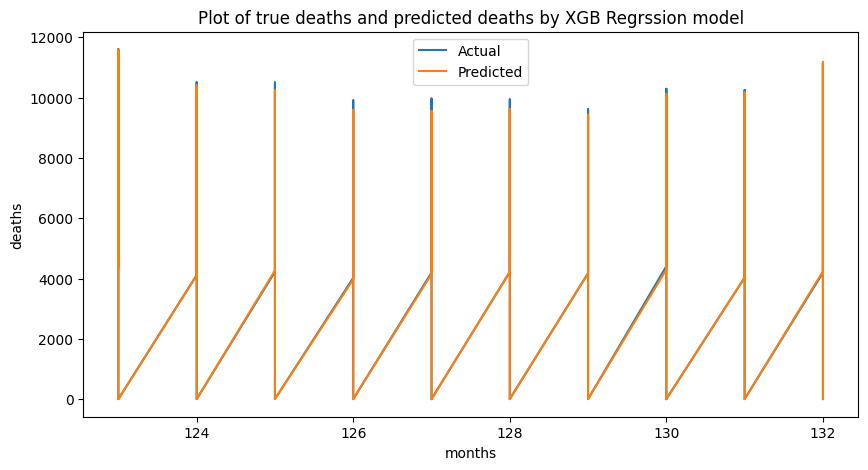

In [ ]:
# plot of predicts of XGB Regression
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(test_x['month'],test_y, label='Actual')
plt.plot(test_x['month'],xgb_predict, label='Predicted')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths by XGB Regrssion model')
plt.legend()
plt.show()

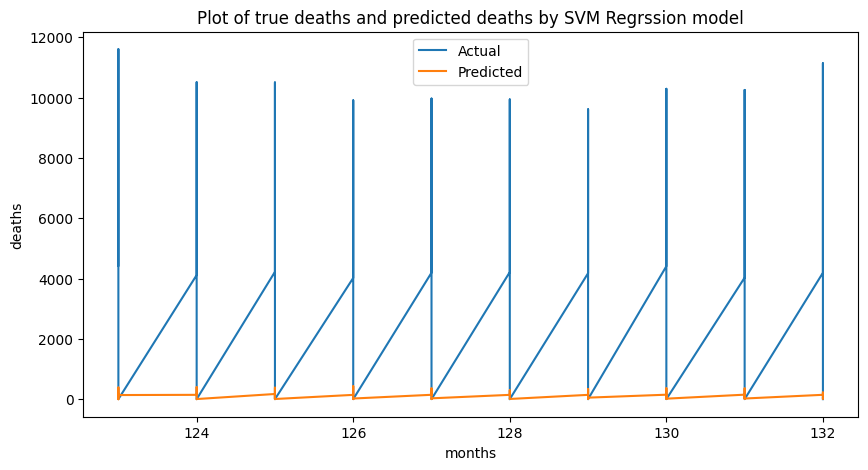

In [ ]:
# plot of predicts of SVM Regression
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(test_x['month'],test_y, label='Actual')
plt.plot(test_x['month'],svm_pred,label='Predicted')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths by SVM Regrssion model')
plt.legend()
plt.show()

In [ ]:
# adding the lables true and predicted labels to test_x
results_df = pd.DataFrame({'test_y': test_y, 'xgb_predict': xgb_predict})
test_x=pd.concat([test_x, results_df], axis=1)
test_x

,month,resstatus_avg_death,sex_avg_death,race_avg_death,death_count_lag_12,resstatus_avg_death_lag_12,sex_avg_death_lag_12,race_avg_death_lag_12,race_code_1,race_code_2,...,cause_4,cause_5,cause_6,cause_7,res_status_1,res_status_2,res_status_3,res_status_4,test_y,xgb_predict
22297,123,1018.750000,457.142857,1050.500000,4167.0,973.125000,441.071429,1017.500000,1,0,...,0,0,0,0,1,0,0,0,4432,4348.332520
22298,123,3347.750000,1031.066667,3407.250000,10184.0,2985.625000,1024.642857,3147.000000,1,0,...,0,0,0,0,1,0,0,0,11318,11158.483398
22299,123,390.375000,185.000000,513.571429,1178.0,347.125000,136.615385,402.000000,1,0,...,0,0,0,0,1,0,0,0,1363,1359.049805
22300,123,917.000000,417.538462,935.250000,3260.0,777.750000,313.666667,818.125000,1,0,...,1,0,0,0,1,0,0,0,3849,3377.958496
22301,123,215.250000,75.461538,282.375000,490.0,200.625000,62.857143,261.250000,1,0,...,0,1,0,0,1,0,0,0,537,526.309509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24183,132,3.000000,269.428571,169.571429,3.0,2.250000,278.785714,181.428571,0,1,...,0,0,1,0,0,0,0,1,1,4.486989
24184,132,2.800000,227.600000,38.428571,1.0,4.000000,274.923077,32.000000,0,0,...,0,0,0,0,0,0,0,1,2,1.446334
24185,132,8.833333,1048.066667,91.750000,4.0,7.166667,1142.785714,83.375000,0,0,...,0,0,0,0,0,0,0,1,6,3.087110
24186,132,2.250000,135.133333,15.428571,0.0,0.000000,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,1,1,1.328630


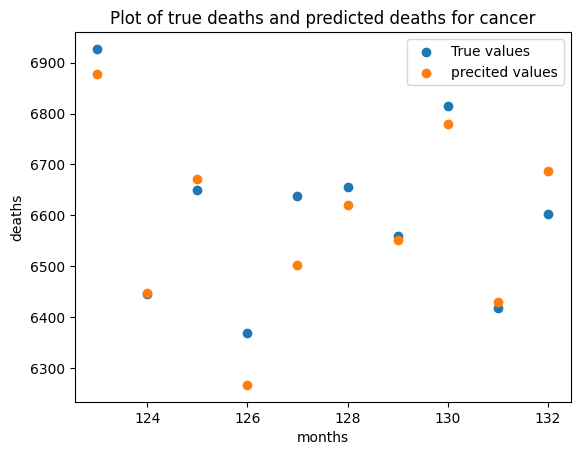

The MAE for the true and prediced for cancer disease  0.007309580058200491


In [ ]:
from  sklearn.metrics import mean_absolute_percentage_error as mape
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_1']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for cancer')
plt.legend()
plt.show()
print('The MAE for the true and prediced for cancer disease ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))

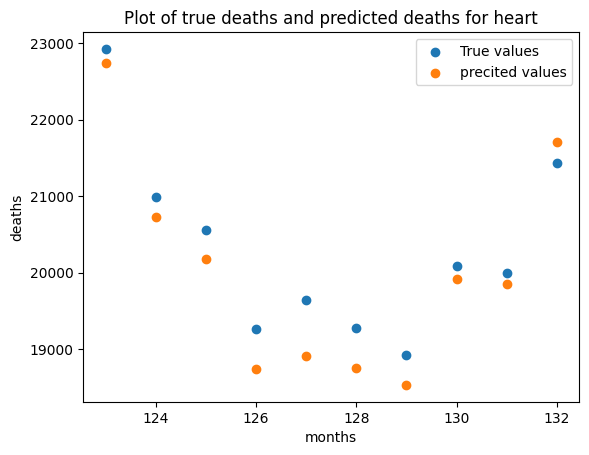

The MAE for the true and prediced for heart disease  0.01805497949768734


In [ ]:
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_2']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for heart')
plt.legend()
plt.show()
print('The MAE for the true and prediced for heart disease ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))

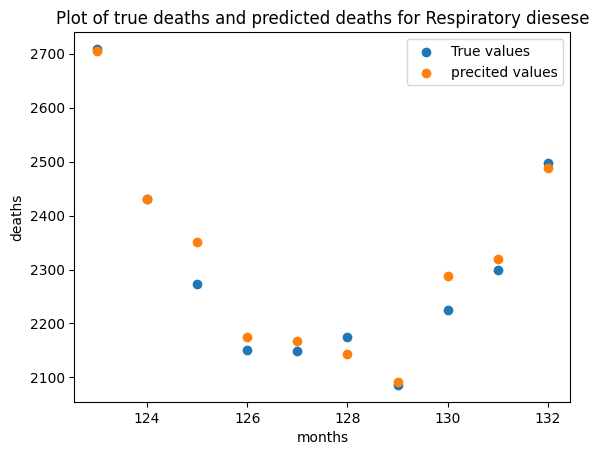

The MAE for the true and prediced for Respiratory disease  0.011428518836459149


In [ ]:
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_3']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for Respiratory diesese')
plt.legend()
plt.show()
print('The MAE for the true and prediced for Respiratory disease ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))

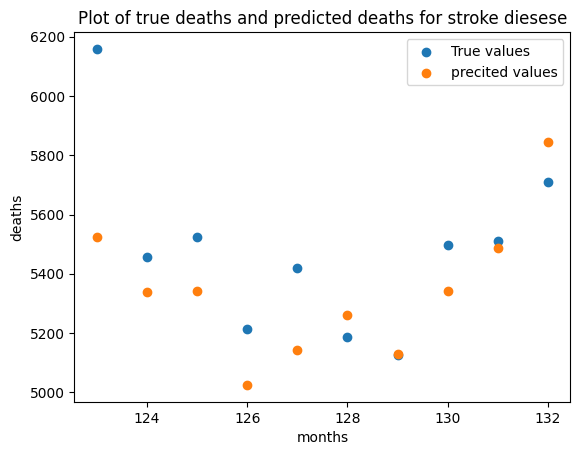

The MAE for the true and prediced for stroke deaths  0.031607729792125804


In [ ]:
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_4']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for stroke diesese')
plt.legend()
plt.show()
print('The MAE for the true and prediced for stroke deaths ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))

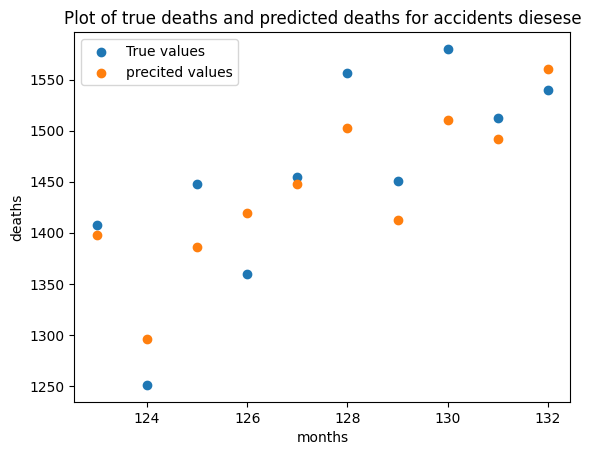

The MAE for the true and prediced for accidents deaths  0.026596042451596136


In [ ]:
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_5']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for accidents diesese')
plt.legend()
plt.show()
print('The MAE for the true and prediced for accidents deaths ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))

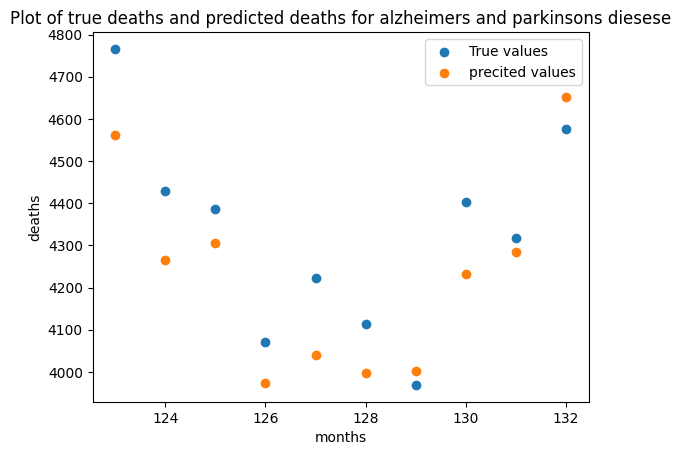

The MAE for the true and prediced for alzheimers and parkinsons disease  0.026469562843458905


In [ ]:
cond_df = test_x[(test_x['res_status_1'] == 1) & (test_x['race_code_1'] == 1) & (test_x['cause_6']==1)]
plt.scatter(range(123,133),cond_df[['month','test_y']].groupby('month').agg("sum"), label= 'True values')
plt.scatter(range(123,133),cond_df[['month','xgb_predict']].groupby('month').agg("sum"), label= 'precited values')
plt.xlabel('months')
plt.ylabel('deaths')
plt.title('Plot of true deaths and predicted deaths for alzheimers and parkinsons diesese')
plt.legend()
plt.show()
print('The MAE for the true and prediced for alzheimers and parkinsons disease ',str(mape(cond_df[['month','test_y']].groupby('month').agg("sum").values,cond_df[['month','xgb_predict']].groupby('month').agg("sum").values)))